<h1 align="center">Fraud detection using Semi Supervised Classification</h1>

## Semi-Supervised Learning** 

s combination of supervised and unsupervised learning processes in which the unlabelled data is used for training a model as well. In this approach, the properties of unspervised learning are used to learn the best possible representation of data and the properties of supervised learning are used to learn the relationships in the representations which are then used to make predictions. 

<p align="center">In this notebook, I use 
    autoencoders to learn the representation of the data 
    a simple linear classifier as a baseline
    a set of unsupervised techniques to perform semi supervised classification.  

I am using the dataset of [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) by ULB machine learning group. 

Note: i will not perform any class balancing technique. 

### Contents 

1. Dataset Preparation  
2. Visualize Fraud Vs Non Fraud Transactions  
3. AutoEncoders : Latent Representation Extraction  
4. Obtain the Latent Representations  
5. Visualize Latent Representations : Fraud vs Non Fraud  
6. Semi supervised techniques

In [152]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("./creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. Let's look at the distribution of target. 

In [153]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Count,count,percent
0,0,284315,0.0
1,1,492,0.0


One of the biggest challenge of this problem is that the **target is highly imbalanced** as only **0.17 %** cases are fraud transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how.  For our use-case let's take only about 1000 rows of non-fraud transactions. 

## Consider only 1000 rows of non fraud cases

In [154]:
import pandas as pd

# Sample 1000 non-fraudulent instances and keep all fraudulent instances
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

# Concatenate non-fraud and fraud DataFrames
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

# Separate features and target
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values

## 2. Visualize Fraud and NonFraud Transactions 

Let's visualize the nature of fraud and non-fraud transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.  

Every dot in the following represents a transaction. Non Fraud transactions are represented as Green while Fraud transactions are represented as Red. The two axis are the components extracted by tsne. 

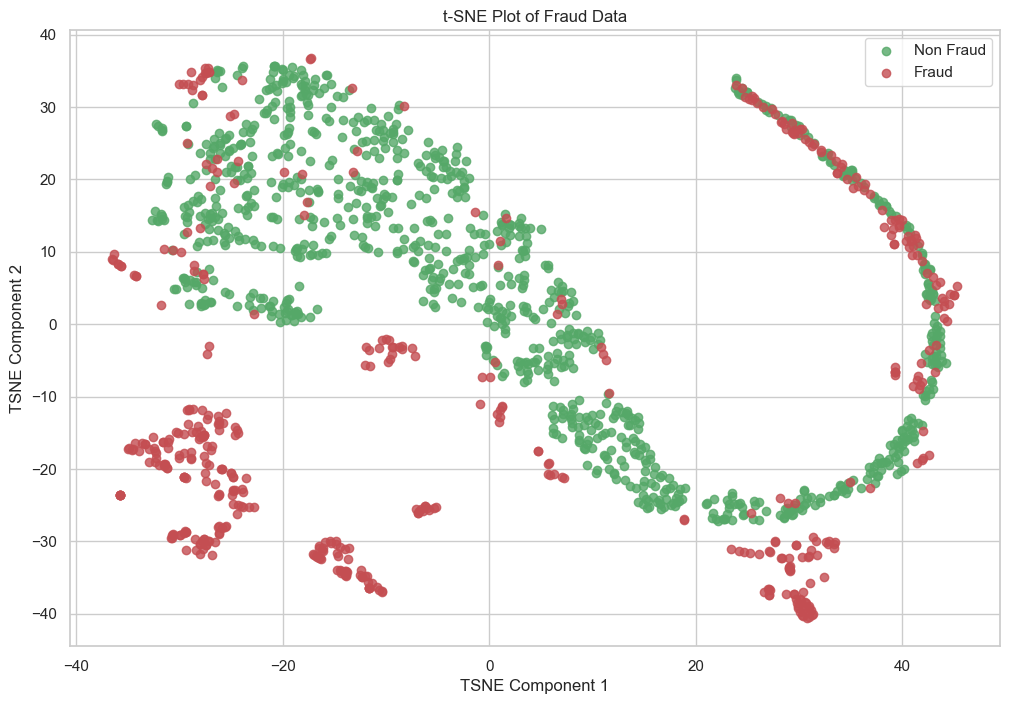

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    
    plt.figure(figsize=(12, 8))
    
    # Plot non-fraud data
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    
    # Plot fraud data
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    
    # Add labels and title
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('t-SNE Plot of Fraud Data')
    plt.legend(loc='best')
    
    # Save and show the plot
    plt.savefig(name)
    plt.show()
    
# Example usage
tsne_plot(X, Y, "original.png")

From the above graph we can observe that there are many non_fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model. 

## 3. AutoEncoders to the rescue 

<br>
*What are Autoencoders?*

Autoencoders are a special type of neural network architectures in which the output is same as the input. 
Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. 
These low level features are then deformed back to project the actual data. 
An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input. 

*For More* - https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases


We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package. 

In [156]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.

In [157]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Before training, let's perform min max scaling. 

In [158]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will use **only 2000 rows** of non fraud cases to train the autoencoder. Additionally, We do not need to run this model for a large number of epochs. 

**Explanation:** The choice of small samples from the original dataset is based on the intuition that one class characteristics (non fraud) will differ from that of the other (fraud). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automaticlly distinuish the other class. 

In [159]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9379 - val_loss: 0.8310
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9373 - val_loss: 0.8304
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9370 - val_loss: 0.8299
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9364 - val_loss: 0.8293
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9353 - val_loss: 0.8287
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9347 - val_loss: 0.8281
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9343 - val_loss: 0.8275
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9336 - val_loss: 0.8269
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9329 - val_loss: 0.8262
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9320 - val_loss: 0.8256


## 4. Obtain the Latent Representations 

Now, the model is trained. We are intereseted in obtaining **latent representation of the input** learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists. 

In [160]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

In [161]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


## 5. Visualize the latent representations : Fraud Vs Non Fraud

Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases. 

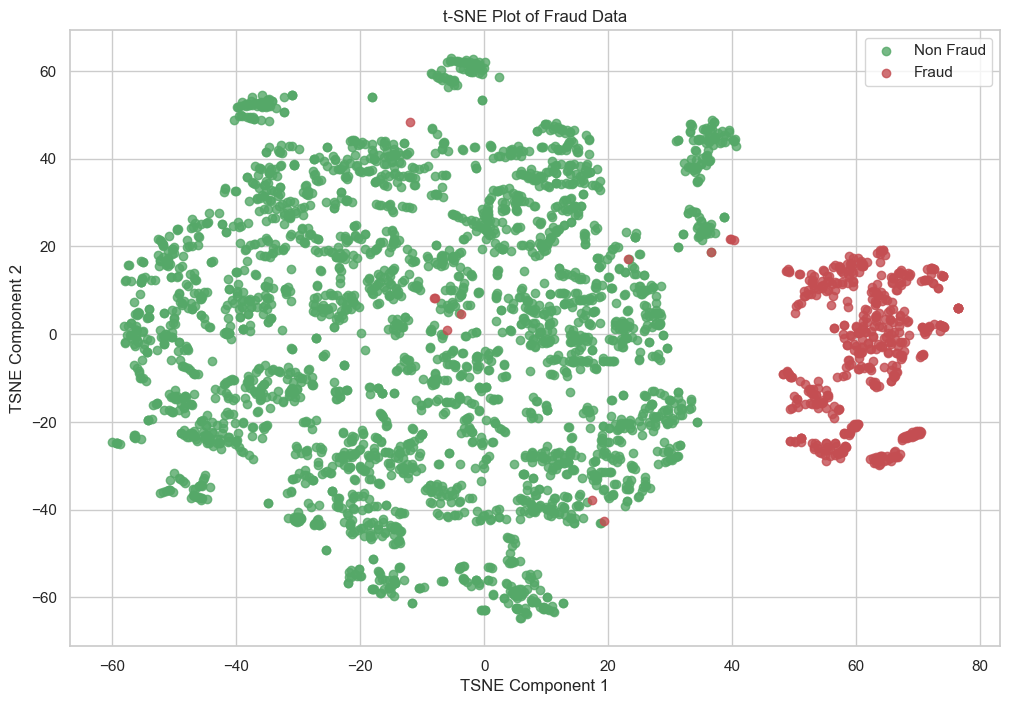

In [162]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

What a perfect graph, we can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict.  Here is the before and after view of Fraud and Non Fraud transactions.

In [163]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


## 7. Applying different algorithms

In [164]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
import pandas as pd

In [165]:
X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size=0.25)

### Supervised technique: Supervised baseline

In [166]:
clf = LogisticRegression(solver="lbfgs").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))
print ("Precision Score: ", precision_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("F1 Score: ", f1_score(y_test, y_pred))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.91      0.95       131

    accuracy                           0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.99       873


Accuracy Score:  0.9862542955326461
Precision Score:  1.0
Recall Score:  0.9083969465648855
F1 Score:  0.952


## Semi supervised techniques

In [167]:
def print_cm(y_test, y_pred):
    '''
    confusion matrix print function
    '''
    km_cm=confusion_matrix(y_test, y_pred)
    
    df_cm = pd.DataFrame(km_cm,
                      ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    pyplot.figure(figsize = (8,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')

In [168]:
def train(X, clf: BaseEstimator, ensembleSize: int = 5, sampleSize: int = 10000, replace: bool = False):
    """
    Trains an ensemble of anomaly detection models by fitting the given classifier multiple times on different 
    random subsets of the input data.

    Parameters:
    -----------
    X : array-like or DataFrame, shape (n_samples, n_features)
        The input data on which the models will be trained.

    clf : BaseEstimator
        The anomaly detection model to be used. This function is suitable for models like Isolation Forest 
        or One-Class SVM, but not suitable for Local Outlier Factor (LOF) due to its neighborhood-based approach.

    ensembleSize : int, optional (default=5)
        The number of models in the ensemble. Each model is trained on a different random subset of the data.

    sampleSize : int, optional (default=10000)
        The size of each random subset of the data used for training individual models. If sampleSize is larger than 
        the total number of samples in X, sampling with replacement will be automatically enabled.

    replace : bool, optional (default=False)
        Whether to sample with replacement when creating random subsets. This is automatically set to True if 
        sampleSize exceeds the number of samples in X.

    Returns:
    --------
    mdlLst : list of BaseEstimator
        A list containing the trained models that constitute the ensemble.

    Notes:
    ------
    The following function is particularly useful in scenarios where an ensemble of anomaly detection models can provide 
    robustness against overfitting and improve generalization on unseen data. However, this approach is not 
    applicable to Local Outlier Factor (LOF) because LOF relies on the local density of data points, which 
    may not be preserved across random subsets of the data. As a result, creating an ensemble of LOF models 
    could lead to inconsistent and unreliable predictions.

    The use of an ensemble is beneficial here because:
    - **Diversity:** By training each model on a different subset of data, the ensemble captures diverse patterns of anomalies, 
      reducing the risk of missing subtle anomalies that may not be detected by a single model.
    - **Stability:** An ensemble averages out the errors of individual models, leading to more stable and reliable predictions.
    - **Robustness:** The ensemble approach is more robust to noise and variations in the data, which is particularly important 
      in anomaly detection tasks where the signal-to-noise ratio is often low.

    """

    # Initialize an empty list to store the trained models
    mdlLst = []
    X_df = pd.DataFrame(X)  # Ensure input data is in DataFrame format for compatibility with pandas sampling

    # Check if sampleSize exceeds the number of rows in X and adjust the sampling method accordingly
    if sampleSize > len(X_df):
        replace = True  # If sample size exceeds data size, sample with replacement

    # Train ensembleSize number of models on random subsets of the data
    for n in range(ensembleSize):
        # Randomly sample data from X_df; use 'replace' to handle cases where sampleSize is large
        X_sample = X_df.sample(sampleSize, replace=replace)
        # Fit the model on the sampled data
        clf.fit(X_sample)
        # Append the trained model to the list
        mdlLst.append(clf)

    return mdlLst

In [169]:

def predict(X, mdlLst):
    """
    Predict anomaly scores for the dataset X using an ensemble of models.

    This function computes the anomaly scores by aggregating the outputs of multiple fitted models. 
    It is designed to work with models that have a `decision_function` method, which is typically
    available in models like `OneClassSVM`. This method is not applicable for models such as 
    `LocalOutlierFactor` (LOF) which do not have a `decision_function` method.

    Args:
        X (numpy.ndarray or pandas.DataFrame): The input data for which predictions are to be made. 
            It should be in the form of a 2D array or DataFrame where rows represent samples and columns represent features.
        mdlLst (list of BaseEstimator): A list of trained models that should have a `decision_function` method. 
            The models are assumed to be already fitted and used to compute anomaly scores.

    Returns:
        numpy.ndarray: An array of average anomaly scores for each sample in X. The scores are computed by averaging
            the outputs of all models in the ensemble. Each score indicates the degree of anomaly for a corresponding sample.
    """
    
    # Initialize an array to hold the cumulative anomaly scores
    y_pred = np.zeros(X.shape[0])
    
    # Iterate over each model in the ensemble
    for clf in mdlLst:
        # Compute the decision function scores for the current model
        # decision_function should be a method available in the model, returning anomaly scores
        y_pred += clf.decision_function(X).reshape(X.shape[0],)
    
    # Average the anomaly scores across all models
    y_pred = (y_pred * 1.0) / len(mdlLst)
    
    return y_pred

In [170]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score
from matplotlib import pyplot
import seaborn as sn

### Isolation forest

In [171]:
from sklearn.ensemble import IsolationForest

alg = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01,
                      max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

#train
if_mdlLst = alg.fit(X_train)

# Get anomaly scores for X_test
if_y_pred = alg.decision_function(X_test)

# Invert scores if necessary
if_y_pred = 1 - if_y_pred

# Create class labels based on the decision function with a custom threshold
if_y_pred_class = if_y_pred.copy()
if_y_pred_class[if_y_pred >= np.percentile(if_y_pred, 95)] = 1
if_y_pred_class[if_y_pred < np.percentile(if_y_pred, 95)] = 0

### Kmeans

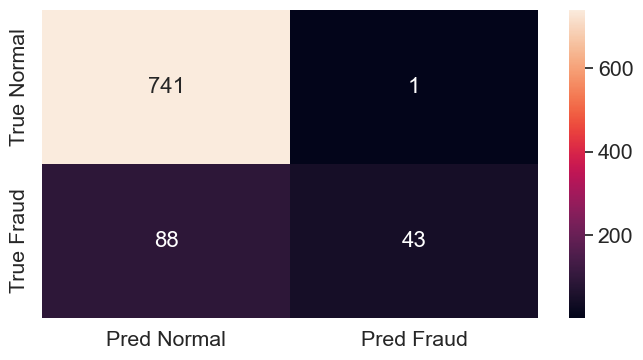

In [172]:
from sklearn.cluster import KMeans
import numpy as np

# Fit KMeans on the training data
kmeans = KMeans(n_clusters=8, random_state=42).fit(X_train)

# Predict the cluster labels for the test data
X_test_clusters = kmeans.predict(X_test)

# Get the cluster centers from the trained model
X_test_clusters_centers = kmeans.cluster_centers_

# Calculate the distance from each point in the test set to its corresponding cluster center
dist = [np.linalg.norm(x - X_test_clusters_centers[cluster]) for x, cluster in zip(X_test, X_test_clusters)]

# Convert distances to a NumPy array for easier processing
km_y_pred = np.array(dist)

# Apply a threshold based on the 95th percentile to classify points as outliers (1) or inliers (0)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

print_cm(y_test, km_y_pred)

### LOF

Local Outlier Factor only looks at the local neighbourhood of a data point and hence cannot make predictions on out of sample data points. Hence we work directly with X_test here.

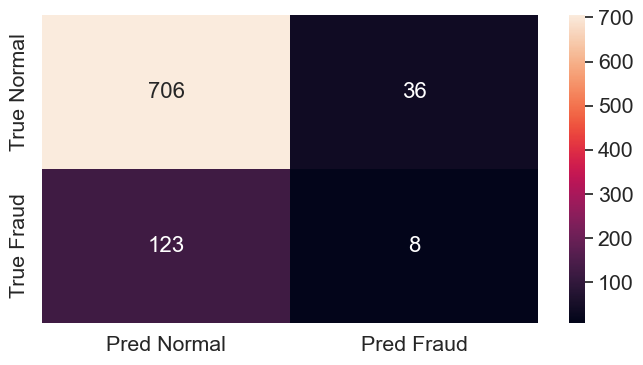

In [173]:
clf=LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=-1)
clf.fit(X_test)

lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

print_cm(y_test, lof_y_pred_class)

### One-Class SVM

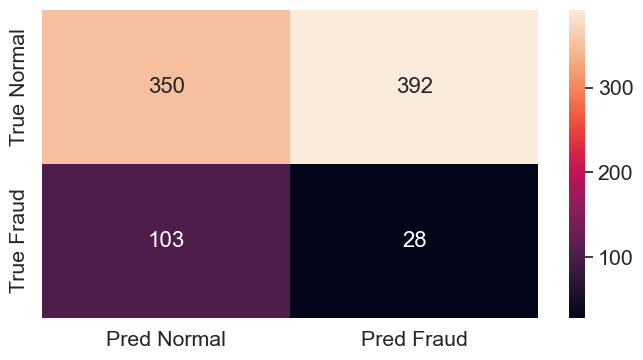

In [174]:
alg=OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=500, verbose=False, max_iter=-1)

osvm_mdlLst=train(X_train,alg)


osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

print_cm(y_test, osvm_y_pred_class)

## Scores

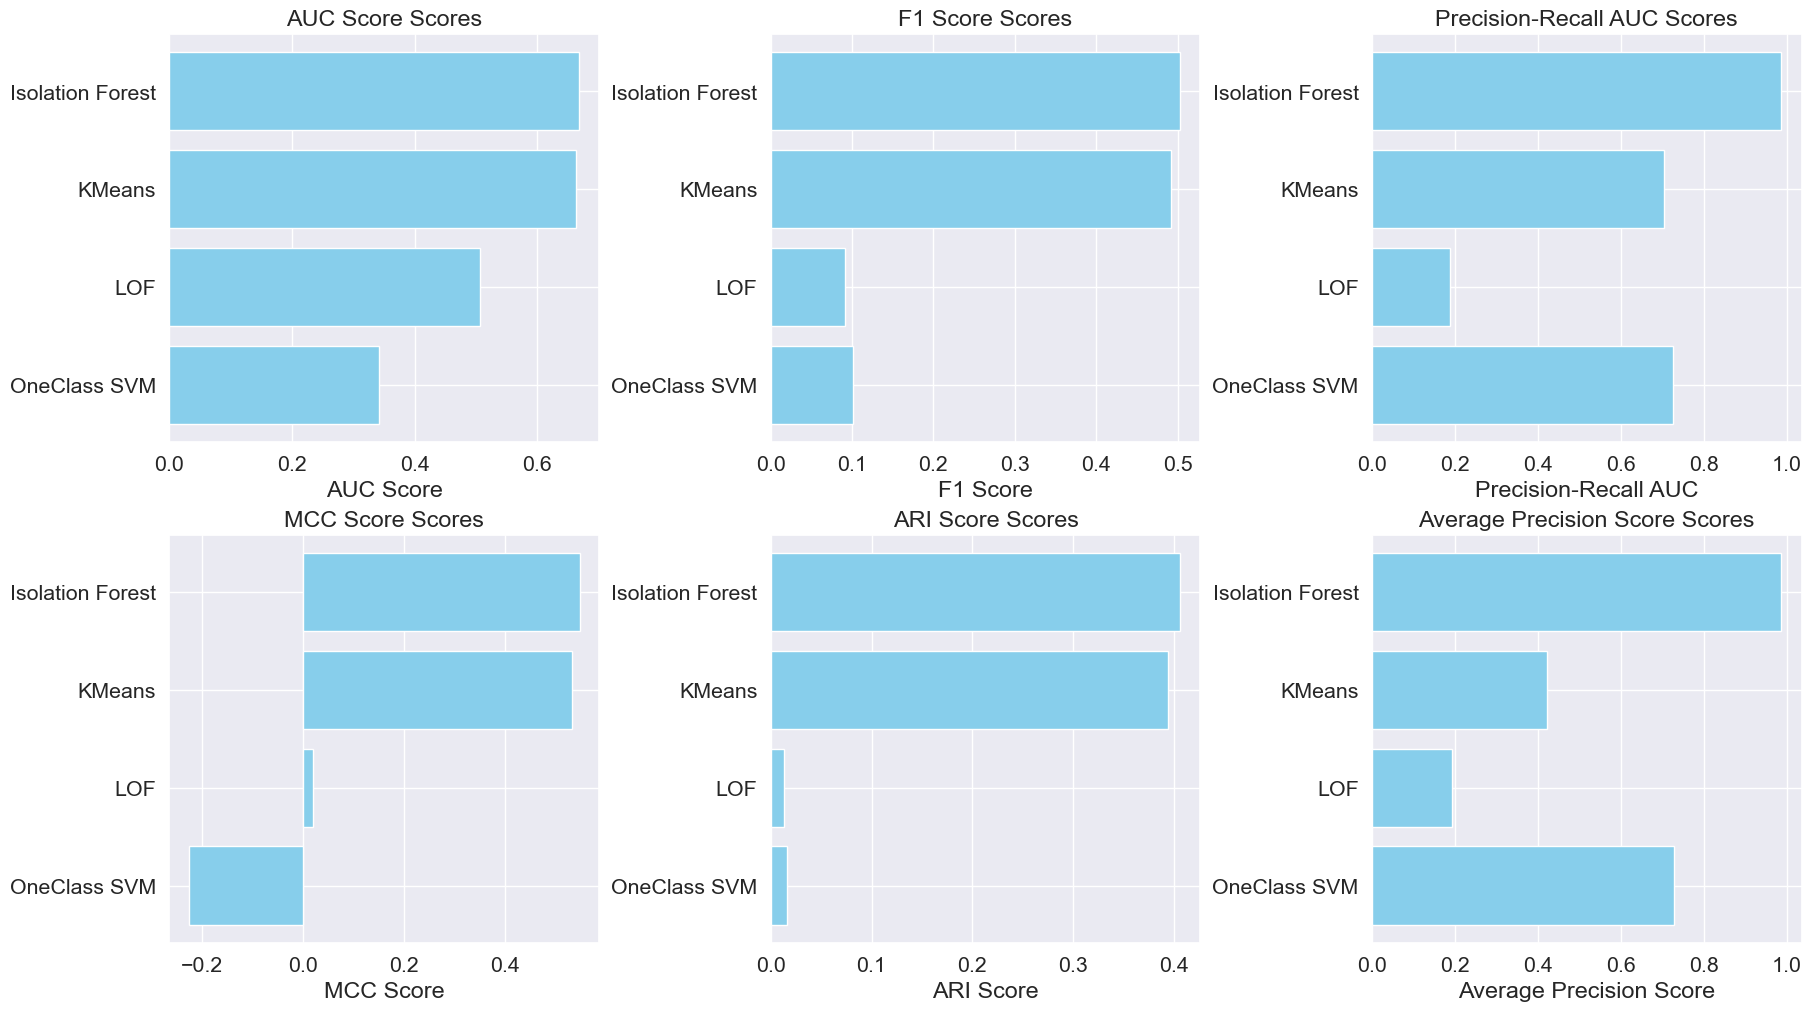

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, matthews_corrcoef, adjusted_rand_score, average_precision_score

# Define the function to calculate Precision-Recall AUC
def calculate_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Calculate metrics for all algorithms
auc_scores = {
    'Isolation Forest': roc_auc_score(y_test, if_y_pred_class),
    'KMeans': roc_auc_score(y_test, km_y_pred),
    'LOF': roc_auc_score(y_test, lof_y_pred_class),
    'OneClass SVM': roc_auc_score(y_test, osvm_y_pred_class)
}

f1_scores = {
    'Isolation Forest': f1_score(y_test, if_y_pred_class),
    'KMeans': f1_score(y_test, km_y_pred),
    'LOF': f1_score(y_test, lof_y_pred_class),
    'OneClass SVM': f1_score(y_test, osvm_y_pred_class)
}

pr_auc_scores = {
    'Isolation Forest': calculate_pr_auc(y_test, if_y_pred),
    'KMeans': calculate_pr_auc(y_test, km_y_pred),
    'LOF': calculate_pr_auc(y_test, lof_y_pred),
    'OneClass SVM': calculate_pr_auc(y_test, osvm_y_pred)
}

mcc_scores = {
    'Isolation Forest': matthews_corrcoef(y_test, if_y_pred_class),
    'KMeans': matthews_corrcoef(y_test, km_y_pred),
    'LOF': matthews_corrcoef(y_test, lof_y_pred_class),
    'OneClass SVM': matthews_corrcoef(y_test, osvm_y_pred_class)
}

ari_scores = {
    'Isolation Forest': adjusted_rand_score(y_test, if_y_pred_class),
    'KMeans': adjusted_rand_score(y_test, km_y_pred),
    'LOF': adjusted_rand_score(y_test, lof_y_pred_class),
    'OneClass SVM': adjusted_rand_score(y_test, osvm_y_pred_class)
}

auprc_scores = {
    'Isolation Forest': average_precision_score(y_test, if_y_pred),
    'KMeans': average_precision_score(y_test, km_y_pred),
    'LOF': average_precision_score(y_test, lof_y_pred),
    'OneClass SVM': average_precision_score(y_test, osvm_y_pred)
}

# Determine the best algorithm for each metric
best_auc = max(auc_scores, key=auc_scores.get)
best_f1 = max(f1_scores, key=f1_scores.get)
best_pr_auc = max(pr_auc_scores, key=pr_auc_scores.get)
best_mcc = max(mcc_scores, key=mcc_scores.get)
best_ari = max(ari_scores, key=ari_scores.get)
best_auprc = max(auprc_scores, key=auprc_scores.get)

# Create a combined dataframe for easier plotting
results = pd.DataFrame({
    'Algorithm': list(auc_scores.keys()),
    'AUC Score': list(auc_scores.values()),
    'F1 Score': list(f1_scores.values()),
    'Precision-Recall AUC': list(pr_auc_scores.values()),
    'MCC Score': list(mcc_scores.values()),
    'ARI Score': list(ari_scores.values()),
    'Average Precision Score': list(auprc_scores.values())
})

# Define the scoring system
def add_winner_column(df, best_algorithms):
    scoring = {algo: 0 for algo in df['Algorithm']}
    for metric, best_alg in best_algorithms.items():
        sorted_algorithms = sorted(df['Algorithm'], key=lambda x: df[metric][df['Algorithm'] == x].values[0], reverse=True)
        for i, algo in enumerate(sorted_algorithms):
            scoring[algo] += (5 - i)  # Assigning 5 points to the best, 4 to the second best, etc.
    df['Final Score'] = df['Algorithm'].map(scoring)
    return df

# Define the best algorithms for each metric
best_algorithms = {
    'AUC Score': best_auc,
    'F1 Score': best_f1,
    'Precision-Recall AUC': best_pr_auc,
    'MCC Score': best_mcc,
    'ARI Score': best_ari,
    'Average Precision Score': best_auprc
}

results = add_winner_column(results, best_algorithms)

# Plot the metrics for each algorithm
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()
metrics = ['AUC Score', 'F1 Score', 'Precision-Recall AUC', 'MCC Score', 'ARI Score', 'Average Precision Score']

for i, metric in enumerate(metrics):
    axes[i].barh(results['Algorithm'], results[metric], color='skyblue')
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'{metric} Scores')
    axes[i].invert_yaxis()

plt.show()

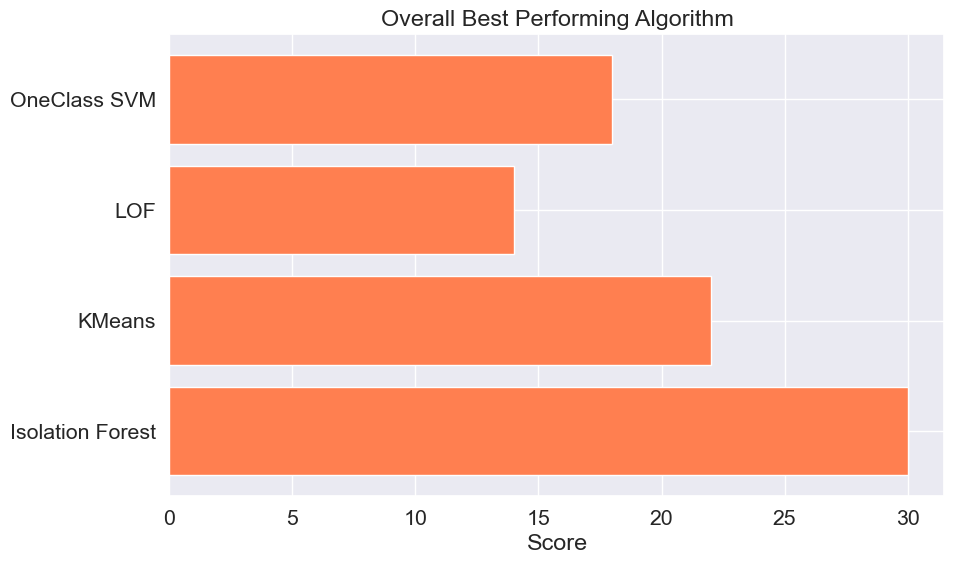

,Algorithm,AUC Score,F1 Score,Precision-Recall AUC,MCC Score,ARI Score,Average Precision Score,Final Score
0,Isolation Forest,0.667939,0.502857,0.986394,0.548296,0.405622,0.986452,30
1,KMeans,0.663448,0.491429,0.703159,0.533635,0.393506,0.421586,22
2,LOF,0.506276,0.091429,0.188904,0.020489,0.013230,0.192714,14
3,OneClass SVM,0.342719,0.101633,0.727009,-0.224838,0.016699,0.727514,18


In [176]:
# Plot overall best performing algorithm across all metrics
fig, ax = plt.subplots(figsize=(10, 6))
overall_scores = results.set_index('Algorithm')['Final Score'].to_dict()
best_algorithm = max(overall_scores, key=overall_scores.get)

ax.barh(list(overall_scores.keys()), list(overall_scores.values()), color='coral')
ax.set_xlabel('Score')
ax.set_title('Overall Best Performing Algorithm')

plt.show()

# Display results dataframe
import pandas as pd
from IPython.display import display

display(results)

Isolation performs better according to the considered metrics